In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.integrate import simpson
from mpl_toolkits.mplot3d import Axes3D

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Afin de rendre le problème continue et convexe sur $\mathbb{R}^{[\Omega]}$, on reformule le problème en terme de $\phi$ pour obtenir au final ce nouveau problème d'optimisation:

La fonction d'énergie pour la segmentation de Chan-Vese peut être représentée comme suit :

$$\left(\phi^{*}, c_{1}^{*}, c_{2}^{*}\right)= \underset{\substack{\phi \in \mathbb{R}^{|\Omega|} \\c_{1} \in [0 ; 255] \\c_{2} \in [0 ; 255]}}{\mathrm{argmin}} \int_{\Omega}||\nabla H(\phi(x))||dx+ \\ 
\lambda \int_{\Omega}\left|I(x)-c_{1}\right|^{2} H(\phi(x)) d x+\lambda \int_{\Omega}\left|I(x)-c_{2}\right|^{2}(1-H(\phi(x))) d x
$$

Ici :


$\bullet$ $\phi$ désigne la fonction de distance signée, qui représente l'évolution du contour au fil des itérations.

$\bullet$ $\mu$ contrôle le compromis entre la longueur du contour et l'ajustement de la région.

$\bullet$ $\lambda$ contrôle l'influence des termes d'ajustement des données.

$\bullet$ I(x) représente l'intensité de l'image au pixel x.

$\bullet$ $c_1$ et $c_2$ représentent les valeurs moyennes d'intensité à l'intérieur des régions de l'objet et de l'arrière-plan, respectivement.

$\bullet$ $H(\phi(x))$ est la fonction de Heaviside, qui passe doucement de 0 à 1 autour de l'ensemble de niveau zéro de $\phi$.




En minimisant la fonction d'énergie par rapport à $c_1$, $c_2$ et $\phi$, nous pouvons obtenir le résultat de segmentation souhaité.On fait alors une descente de gradient classique sur ce nouveau problème d'optimisation.




D'abord on aura besoin de ses fonctions suivantes pour résoudre ce problème

In [2]:

def signed_distance_from_mask(mask):
    Dm = fast_marching(mask)
    Dp = fast_marching(1 - mask)
    phi = Dp - Dm
    return phi

def fast_marching(mask):
    nbc, nbl = mask.shape[:2]
    D = np.ones((nbc, nbl)) * 1000000.0

    for i in range(nbc):
        for j in range(nbl):
            if mask[i, j] == 1:
                D[i, j] = 0

    for j in range(nbl):
        for i in range(nbc):
            if i > 0:
                if D[i - 1, j] + 1.0 < D[i, j]:
                    D[i, j] = D[i - 1, j] + 1.0
            if j > 0:
                if D[i, j - 1] + 1.0 < D[i, j]:
                    D[i, j] = D[i, j - 1] + 1.0
            if i > 0 and j > 0:
                if D[i - 1, j - 1] + np.sqrt(2.0) < D[i, j]:
                    D[i, j] = D[i - 1, j - 1] + np.sqrt(2.0)
            if i < nbc - 1 and j > 0:
                if D[i + 1, j - 1] + np.sqrt(2.0) < D[i, j]:
                    D[i, j] = D[i + 1, j - 1] + np.sqrt(2.0)

    for i in range(nbc - 2, -1, -1):
        for j in range(nbl):
            if D[i + 1, j] + 1.0 < D[i, j]:
                D[i, j] = D[i + 1, j] + 1.0

    for j in range(nbl - 1, -1, -1):
        for i in range(nbc - 1, -1, -1):
            if i < nbc - 1:
                if D[i + 1, j] + 1.0 < D[i, j]:
                    D[i, j] = D[i + 1, j] + 1.0
            if j < nbl - 1:
                if D[i, j + 1] + 1.0 < D[i, j]:
                    D[i, j] = D[i, j + 1] + 1.0
            if i < nbc - 1 and j < nbl - 1:
                if D[i + 1, j + 1] + np.sqrt(2.0) < D[i, j]:
                    D[i, j] = D[i + 1, j + 1] + np.sqrt(2.0)
            if i > 0 and j < nbl - 1:
                if D[i - 1, j + 1] + np.sqrt(2.0) < D[i, j]:
                    D[i, j] = D[i - 1, j + 1] + np.sqrt(2.0)

    for i in range(1, nbc):
        if D[i - 1, j] + 1.0 < D[i, j]:
            D[i, j] = D[i - 1, j] + 1.0

    return D

def heavyside_eta(phi, eta):
    M = (1. + 2. * np.arctan(phi / eta) / np.pi) / 2.
    return M

def delta_eta(phi, eta):
    M = 1. / ((1 + (phi / eta) ** 2) * eta * np.pi)
    return M

def gradx(I):
    m, n = I.shape
    M = np.zeros((m, n))
    M[:-1, :] = I[1:, :] - I[:-1, :]
    return M

def grady(I):
    m, n = I.shape
    M = np.zeros((m, n))
    M[:, :-1] = I[:, 1:] - I[:, :-1]
    return M

def div(px, py):
    m, n = px.shape
    M = np.zeros((m, n))
    Mx = np.zeros((m, n))
    My = np.zeros((m, n))

    Mx[1:m-1, :] = px[1:m-1, :] - px[:m-2, :]
    Mx[0, :] = px[0, :]
    Mx[m-1, :] = -px[m-2, :]

    My[:, 1:n-1] = py[:, 1:n-1] - py[:, :n-2]
    My[:, 0] = py[:, 0]
    My[:, n-1] = -py[:, n-2]

    M = Mx + My
    return M

def integral(zz):
    # Integrate over the 2 dimensions
    dim = zz.shape
    Y = np.arange(dim[0])
    X = np.arange(dim[1])
    return simpson([simpson(zz_x,X) for zz_x in zz],Y)


# Function to update color constants c1 and c2
def update_color_constants(phi, image,eta):
    #compute Heavyside
    H = heavyside_eta(phi, eta)
    #compute c1
    numerator1 = np.sum(H * image)
    denominator1 = np.sum(H)
    c1=numerator1 / denominator1
    #compute c2
    numerator2 = np.sum((1-H) * image)
    denominator2 = np.sum(1-H)
    c2=numerator2 / denominator2
    
    return c1, c2

#Function to compute graf_phi
def grad_phi(img, phi, eta, eps, lamb, c1, c2):
    gx, gy = gradx(phi), grady(phi)
    norm = np.sqrt(np.sum(gx**2 + gy**2 + eps**2))
    px, py = gx/norm, gy/norm
    return -delta_eta(phi, eta) * (div(px, py) + lamb*((img - c2)**2 - (img - c1)**2))






def update_phi(img, phi, eta=1, eps=1, lamb=1e-4, n=1500, threshold=4e-1):    
    #update the color constant c1 and c2
    c1,c2 = update_color_constants(phi, image,eta)
    #calculate de gradient 
    gradient = grad_phi(img, phi, eta, eps, lamb, c1, c2)
    #calculate the step
    tau = 1/(2*np.max(np.max(gradient)))
    #desente de gradient method 
    new_phi = phi - tau*gradient
    phi = new_phi
    return phi

def update_phi_2(img, phi,old_phi,i, eta=1, eps=1, lamb=1e-4, n=10, threshold=1e-1):
    alpha=(lambda n : n/(n+3))
    y = phi + alpha(i)*(phi - old_phi)
    #update the color constant c1 and c2
    c1,c2 = update_color_constants(phi, image,eta)
    #calculate de gradient 
    gradient = grad_phi(img, y, eta, eps, lamb, c1, c2)
    #calculate the step
    tau = 1/(2*np.max(np.max(gradient)))
    #desente de gradient method 
    new_phi = y - tau*gradient
    phi = new_phi
    return y,phi

def contour_chan_vese_fista(img, phi, eta=1, eps=1, lamb=1e-4, n=10, iter_max=1000, threshold=1e-1, freq=100, alpha=(lambda i : i/(i+3)), mask_ref=None, to_print=True):
    old_phi = phi
    func = np.empty((iter_max, 3))
    y = phi
    c1 = update_c1(y, img, eta)
    c2 = update_c2(y, img, eta)
    f1, f2, f3 = (energy(phi, img, c1, c2, lamb, eps, eta))
    func[0] = np.array([f1,f2,f3])
    for i in range(iter_max):
        y = phi + alpha(i)*(phi - old_phi)
        c1 = update_c1(y, img, eta)
        c2 = update_c2(y, img, eta)
        gJ = grad_J_phi(img, y, eta, eps, lamb, c1, c2)
        tau = 1/(2*np.max(np.max(np.abs(gJ))))
        new_phi = y - tau*gJ
        if (i+1)%n == 0:
            # print(i, tau)
            new_phi = signed_distance_from_mask(new_phi>0)
        if type(mask_ref)==type(None):
            dif = np.linalg.norm(heavyside_eta(new_phi, eta) - heavyside_eta(phi, eta))
        else:
            dif = np.linalg.norm(heavyside_eta(new_phi, eta) - heavyside_eta(mask_ref, eta))
        if i>100 and dif < threshold:
            print(f'dif={dif} and i={i}')
            break
        old_phi, phi = y, new_phi
        if to_print and (i+1)%freq == 0:
            plot_phi_image(phi, img)
            print(dif)
        f1, f2, f3 = (energy(phi, img, c1, c2, lamb, eps, eta))
        func[i] = np.array([f1,f2,f3])
    return signed_distance_from_mask(phi>0), func



Initialisation:
   * upload une image
   * initialiser manuellemnt la région d'intéret 

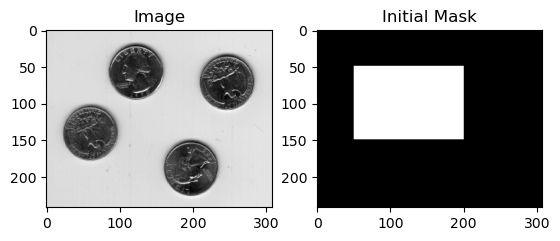

In [3]:
# Step 1: Load an image
image = io.imread('eight.png')
image = image.astype(float)  # Convert image to floating-point

# Step 2: Define an initial region of interest (mask)
mask = np.zeros_like(image)
mask[50:150, 50:200] = 1

# Display the image and the mask
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Initial Mask')
plt.show()

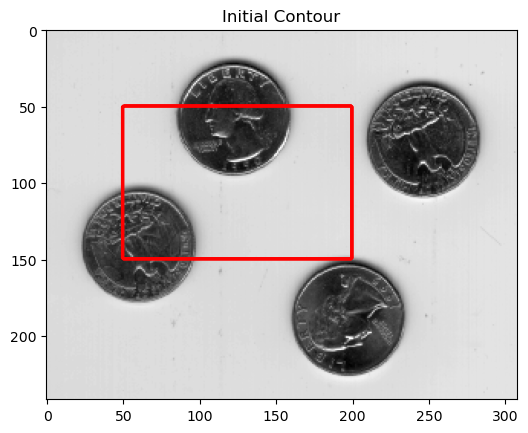

In [4]:
# Display intermediate result
plt.imshow(image, cmap='gray')
plt.contour(mask, colors='r')
plt.title('Initial Contour')
plt.show()

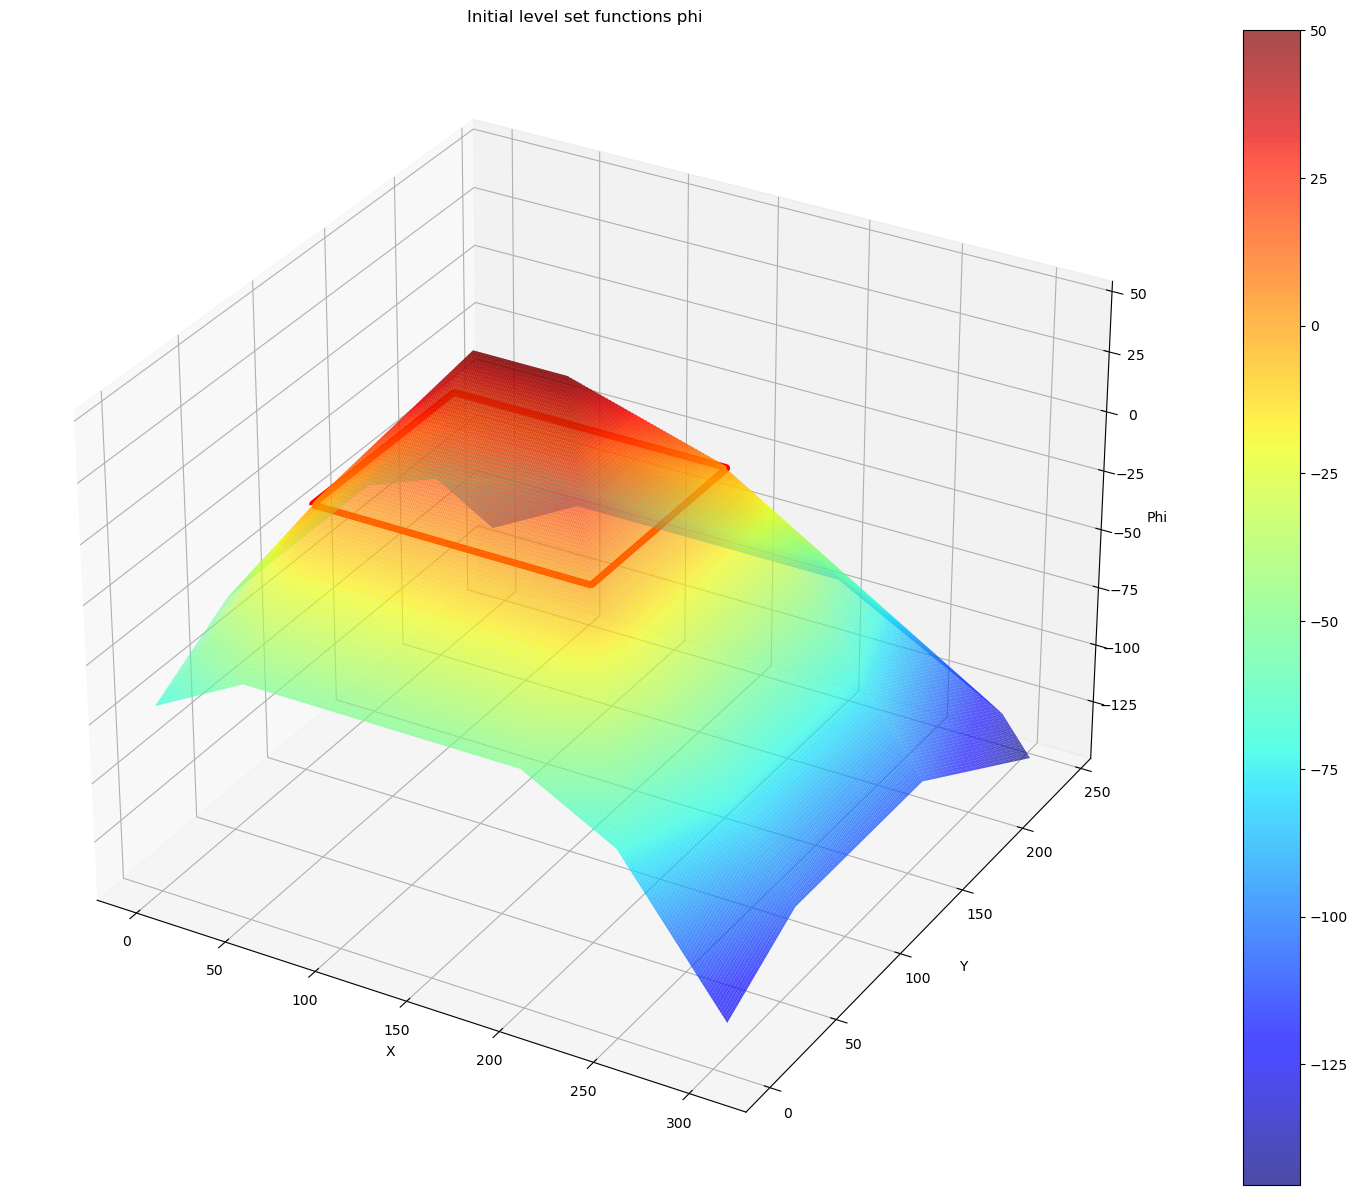

In [5]:
phi=signed_distance_from_mask(mask)
initial_phi=phi

# Visualize the signed distance function in 3D
fig = plt.figure(figsize=(20, 15))  # Adjust the figsize as per your preference
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(phi.shape[1]), range(phi.shape[0]))
surf = ax.plot_surface(x, y, phi, cmap='jet', rstride=1, cstride=1, alpha=0.7)  # Adjust rstride and cstride
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Phi')

# Highlight the contour where phi is 0
contour = ax.contour(x, y, phi, levels=[0], colors='red', linewidths=5, alpha=1)  # Adjust linewidth and alpha values

# Add a colorbar
fig.colorbar(surf)
plt.title('Initial level set functions phi ')
plt.show()

Cette figure représente la fonction de niveau initial $\phi$ dont l'ensemble de niveau zéro {x, $\phi$ = 0} (en rouge) représente un contour d'intérêt dans le domaine de l'image.
d'intérêt dans le domaine de l'image. L'objet d'intérêt est représenté par les pixels $\phi > 0$
(en rouge).


L'algorithme est le suivant : 

Tant que : ||H($\phi^{k+1}$) - H($\phi^{k}$)|| > seuil défini
   * Mettre à jour les coefficients de couleurs $c_1^{k+1}$ et $c_2^{k+1}$
   * Mettre à jour les H($\phi^{k+1}$) avec 
$$ 
\phi^{k+1} = \phi^k + \tau \delta_{\eta}(\phi^k)[\mathop{\rm div} (\frac{\nabla \phi^k}{\lVert \nabla \phi^k(x) \rVert_{\epsilon}} - \lambda(I - c_1^{k+1})^2 - \lambda(I - c_2^{k+1})^2]
$$
   * Toutes les n itérations, mettre à jour $\phi^{k+1}$ en tant que distance signée par rapport à la frontière

In [6]:
# Parameters
eta = 1.0
epsilon = 1.0
lambda_val = 1e-5
threshold=4e-4
n_iterations = 500

n=10
    
phi_sequence = [phi.copy()]

# Level set evolution
for i in range(n_iterations):
    
#     if i % 100 == 0:
#         # Display intermediate result
#         plt.imshow(image, cmap='gray')
#         plt.contour(phi, levels=[0], colors='r')
#         plt.title('Iteration {}'.format(i))
#         plt.show()
    
    new_phi = update_phi(image, phi, eta, epsilon, lambda_val, n_iterations, threshold=4e-1)

    if i % 10 == 0:
        new_phi = signed_distance_from_mask(new_phi>0)
        phi_sequence.append(phi.copy())
    
    dif = np.linalg.norm(heavyside_eta(new_phi, eta) - heavyside_eta(phi, eta))
    phi= new_phi
    
    
    if  i>100 and dif < threshold:
        print(f'dif={dif} and i={i}')
        break
        



KeyboardInterrupt: 

In [ ]:
n=11
# phi=signed_distance_from_mask(phi>0)
def extract_elements(phi_sequence):
    n = len(phi_sequence)
    if n <= 10:
        return phi_sequence
    else:
        step = (n - 1) // 8
        indices = np.arange(0, n, step)
        indices = np.unique(np.concatenate(([0], indices, [n - 1])))
        extracted_elements = [phi_sequence[i] for i in indices]
        return extracted_elements

phi_sequence=extract_elements(phi_sequence)


In [ ]:
# Display the transformation of the contour
plt.figure(figsize=(12, 6))
for i, phi in enumerate(phi_sequence):
    plt.subplot(2, len(phi_sequence)//2, i +1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Iteration {}'.format(i * n))
    plt.axis('off')

# Display the final contour
plt.figure()
plt.imshow(image, cmap='gray')
plt.contour(phi_sequence[-1], levels=[0], colors='r', linewidths=2)
plt.title('Final Contour')
plt.axis('off')

plt.show()


In [ ]:
phi=phi_sequence[-1]
# Visualize the signed distance function in 3D
fig = plt.figure(figsize=(20, 15))  # Adjust the figsize as per your preference
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(phi.shape[1]), range(phi.shape[0]))
surf = ax.plot_surface(x, y, phi, cmap='jet', rstride=1, cstride=1, alpha=0.7)  # Adjust rstride and cstride
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Phi')

# Highlight the contour where phi is 0
contour = ax.contour(x, y, phi, levels=[0], colors='red', linewidths=5, alpha=1)  # Adjust linewidth and alpha values

# Add a colorbar
fig.colorbar(surf)
plt.title('Final level set functions phi ')
plt.show()

In [ ]:
phi1=initial_phi
# Visualize the signed distance function in 3D
fig = plt.figure(figsize=(20, 15))  # Adjust the figsize as per your preference
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(phi1.shape[1]), range(phi1.shape[0]))
surf = ax.plot_surface(x, y, phi1, cmap='jet', rstride=1, cstride=1, alpha=0.7)  # Adjust rstride and cstride
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Phi')

# Highlight the contour where phi is 0
contour = ax.contour(x, y, phi1, levels=[0], colors='red', linewidths=5, alpha=1)  # Adjust linewidth and alpha values

# Add a colorbar
fig.colorbar(surf)
plt.title('Initial level set functions phi ')
plt.show()



# Visualize the signed distance function in 3D
fig = plt.figure(figsize=(20, 15))  # Adjust the figsize as per your preference
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(phi.shape[1]), range(phi.shape[0]))
surf = ax.plot_surface(x, y, phi, cmap='jet', rstride=1, cstride=1, alpha=0.7)  # Adjust rstride and cstride
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Phi')

# Highlight the contour where phi is 0
contour = ax.contour(x, y, phi, levels=[0], colors='red', linewidths=5, alpha=1)  # Adjust linewidth and alpha values

# Add a colorbar
fig.colorbar(surf)
plt.title('Final level set functions phi ')
plt.show()

On peut voir dans les 2 figures au dessus deux fonctions de niveau $\phi$ (avant et après) dont l'ensemble de niveau zéro {x, $\phi$ = 0} (en rouge) représente un contour d'intérêt dans le domaine de l'image.
d'intérêt dans le domaine de l'image. L'objet d'intérêt est représenté par les pixels $\phi > 0$
(en rouge).

=> Les objets sont : un carré (en haut) et les 4 pièces de monnaie de l'exemple précédent (en bas).

In [ ]:
# Display the image and mask
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.contour(initial_phi, levels=[0], colors='r')
plt.title("Initial contour")

plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.contour(phi, levels=[0], colors='r')
plt.title("Final contour")

plt.show()

# COMPARAISON

## Méthode Chan-Vese avec une descente de gradient classique : 


In [ ]:
# Parameters
eta = 1.0
epsilon = 1.0
lambda_val = 1e-5
threshold=4e-4
n_iterations = 500

n=11
    
mask[25:200, 25:275] = 1
phi=signed_distance_from_mask(mask)
initial_phi=phi

phi_sequence = [phi.copy()]

# Level set evolution
for i in range(n_iterations):
    
#     if i % 100 == 0:
#         # Display intermediate result
#         plt.imshow(image, cmap='gray')
#         plt.contour(phi, levels=[0], colors='r')
#         plt.title('Iteration {}'.format(i))
#         plt.show()
    
    new_phi = update_phi(image, phi, eta, epsilon, lambda_val, n_iterations, threshold=4e-1)

    if i % 10 == 0:
        new_phi = signed_distance_from_mask(new_phi>0)
        phi_sequence.append(phi.copy())
    
    dif = np.linalg.norm(heavyside_eta(new_phi, eta) - heavyside_eta(phi, eta))
    phi= new_phi
    
    
    if  i>100 and dif < threshold:
        print(f'dif={dif} and i={i}')
        break


n=11
# phi=signed_distance_from_mask(phi>0)
def extract_elements(phi_sequence):
    n = len(phi_sequence)
    if n <= 10:
        return phi_sequence
    else:
        step = (n - 1) // 8
        indices = np.arange(0, n, step)
        indices = np.unique(np.concatenate(([0], indices, [n - 1])))
        extracted_elements = [phi_sequence[i] for i in indices]
        return extracted_elements

phi_sequence=extract_elements(phi_sequence)
# Display the transformation of the contour
plt.figure(figsize=(12, 6))
for i, phi in enumerate(phi_sequence):
    plt.subplot(2, len(phi_sequence)//2, i +1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Iteration {}'.format(i * n))
    plt.axis('off')

# Display the final contour
plt.figure()
plt.imshow(image, cmap='gray')
plt.contour(phi_sequence[-1], levels=[0], colors='r', linewidths=2)
plt.title('Final Contour')
plt.axis('off')

plt.show()

## Méthode Chan-Vese avec FISTA : 


Changement dans la récursivité:
* $y_n = \phi_n + \alpha_n(\phi_n - \phi_{n-1})$
* $\phi_{n+1} = y_n - \tau*\nabla J(y_n)$


In [ ]:
# Parameters
eta = 1.0
epsilon = 1.0
lambda_val = 1e-5
threshold=4e-4
n_iterations = 500

n=11
    

mask[25:200, 25:275] = 1
phi=signed_distance_from_mask(mask)
initial_phi=phi

phi_sequence_2 = [phi.copy()]
old_phi = phi
y = phi


# Level set evolution
for i in range(n_iterations):
    
#     if i % 100 == 0:
#         # Display intermediate result
#         plt.imshow(image, cmap='gray')
#         plt.contour(phi, levels=[0], colors='r')
#         plt.title('Iteration {}'.format(i))
#         plt.show()
    
    y,new_phi = update_phi_2(image, phi,old_phi,i, eta, epsilon, lambda_val, n_iterations, threshold=4e-1)

    if i % 10 == 0:
        new_phi = signed_distance_from_mask(new_phi>0)
        phi_sequence_2.append(phi.copy())
    
    dif = np.linalg.norm(heavyside_eta(new_phi, eta) - heavyside_eta(phi, eta))
    phi= new_phi
    
    
    if  i>100 and dif < threshold:
        print(f'dif={dif} and i={i}')
        break
    old_phi, phi = y, new_phi



# phi=signed_distance_from_mask(phi>0)
def extract_elements(phi_sequence_2):
    n = len(phi_sequence_2)
    if n <= 10:
        return phi_sequence_2
    else:
        step = (n - 1) // 8
        indices = np.arange(0, n, step)
        indices = np.unique(np.concatenate(([0], indices, [n - 1])))
        extracted_elements = [phi_sequence_2[i] for i in indices]
        return extracted_elements

phi_sequence_2=extract_elements(phi_sequence_2)
# Display the transformation of the contour
plt.figure(figsize=(12, 6))
for i, phi in enumerate(phi_sequence_2):
    plt.subplot(2, len(phi_sequence_2)//2, i +1)
    plt.imshow(image, cmap='gray')
    plt.contour(phi, levels=[0], colors='r', linewidths=2)
    plt.title('Iteration {}'.format(i * n))
    plt.axis('off')

# Display the final contour
plt.figure()
plt.imshow(image, cmap='gray')
plt.contour(phi_sequence_2[-1], levels=[0], colors='r', linewidths=2)
plt.title('Final Contour')
plt.axis('off')

plt.show()

In [ ]:
# Display the image and mask
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.contour(phi_sequence[-1], levels=[0], colors='r', linewidths=2)
plt.title("Méthode Chan-Vese classique")

plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.contour(phi_sequence_2[-1], levels=[0], colors='r', linewidths=2)
plt.title("Méthode Chan-Vese avec FISTA ")

plt.show()

Avec Méthode Chan-Vese avec FISTA on a des meilleurs résultats une convergeance plus rapide qu'avec une methode de descente de gradient classique.